In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Ustawienia wyświetlania
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Projekt: Analiza danych transakcyjnych sklepu online

**Cel projektu:**
Analiza danych transakcyjnych sklepu internetowego (OnlineRetail) z wykorzystaniem metod eksploracji danych.

**Dataset:** 
- Źródło: UCI Machine Learning Repository
- Okres: grudzień 2010 - grudzień 2011
- ~540k transakcji, ~4000 klientów

**Zastosowane metody:**
1. **PCA** - redukcja wymiarów do wizualizacji (Grupa 1 - E4)
2. **K-Means** - segmentacja klientów (Grupa 2 - E5)  
3. **Apriori** - reguły asocjacyjne produktów (Grupa 3 - E5)
4. **Random Forest** - klasyfikacja klientów (dodatkowo - E5)

**Struktura analizy:**
- Krok 0: Wczytanie i czyszczenie danych
- Kroki 1-4: Eksploracyjna analiza danych (EDA)
- Krok 5: Segmentacja RFM + klasteryzacja
- Krok 6: Reguły asocjacyjne
- Krok 7: Klasyfikacja z poprawną walidacją

# Krok 0: wczytanie i czyszczenie danych
- Wczytanie pliku OnlineRetail.csv (ISO-8859-1).
- Usunięcie braków CustomerID i zwrotów (Quantity > 0).
- Dodanie kolumny TotalSum i parsowanie InvoiceDate.

In [281]:
print("--- 0. Wczytywanie i czyszczenie danych ---")

# 1. Wczytanie danych
df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")

--- 0. Wczytywanie i czyszczenie danych ---


In [282]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  str    
 1   StockCode    541909 non-null  str    
 2   Description  540455 non-null  str    
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  str    
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  str    
dtypes: float64(2), int64(1), str(5)
memory usage: 33.1 MB


In [283]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [284]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [285]:
# 2. Usunięcie brakujących klientów
df.dropna(subset=["CustomerID"], inplace=True)

# 3. Konwersja daty
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# 4. Usunięcie błędnych transakcji
df = df[df["Quantity"] > 0]
df = df[df["UnitPrice"] > 0]

# 5. Obliczenie wartości transakcji
df["TotalSum"] = df["Quantity"] * df["UnitPrice"]

# 6. Agregacja miesięczna
df["YearMonth"] = pd.PeriodIndex(df["InvoiceDate"], freq="M")

# 6a. Usunięcie niepełnego ostatniego miesiąca
last_month = df["YearMonth"].max()
df = df[df["YearMonth"] != last_month]
print(f"Usunięto niepełny miesiąc: {last_month}")

monthly_sales = df.groupby("YearMonth")["TotalSum"].sum().reset_index()

monthly_sales["YearMonth"] = monthly_sales["YearMonth"].astype(str)

print(f"Dane gotowe: {df.shape}")


Usunięto niepełny miesiąc: 2011-12
Dane gotowe: (380580, 10)


## 1. Sprzedaż w czasie (miesiące)

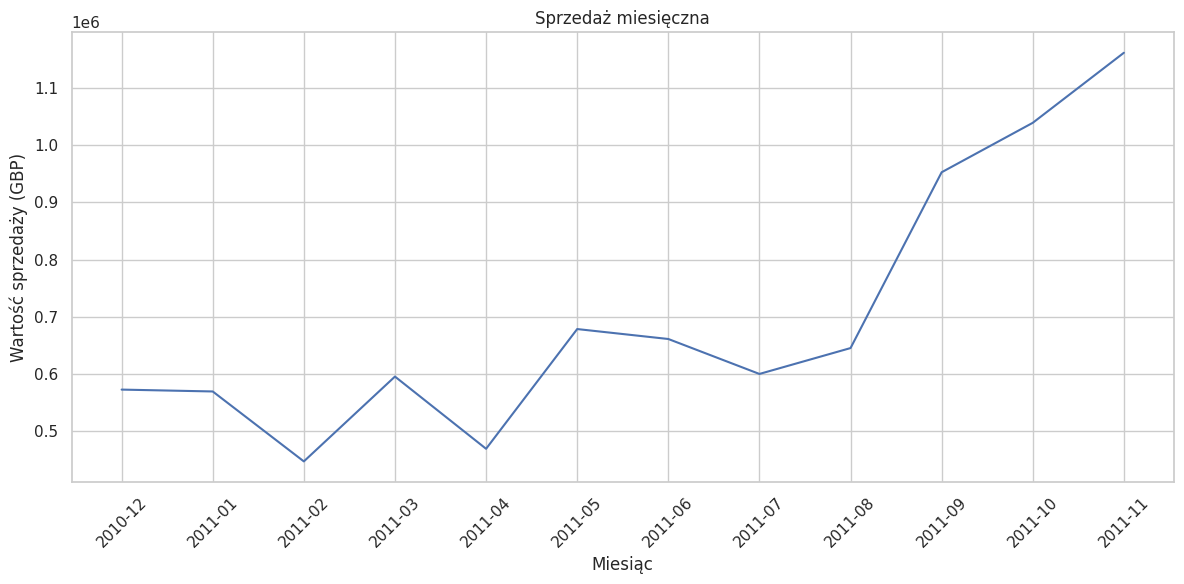

In [286]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales["YearMonth"], monthly_sales["TotalSum"])
plt.xticks(rotation=45)
plt.title("Sprzedaż miesięczna")
plt.xlabel("Miesiąc")
plt.ylabel("Wartość sprzedaży (GBP)")
plt.tight_layout()
plt.show()


- wzrost sprzedaży w drugiej połowie roku

- wyraźny pik przed grudniem (okres świąteczny)

- dane nie obejmują pełnych 2 lat → ostrożnie z trendami

## 2. Top produkty (wg wartości sprzedaży)

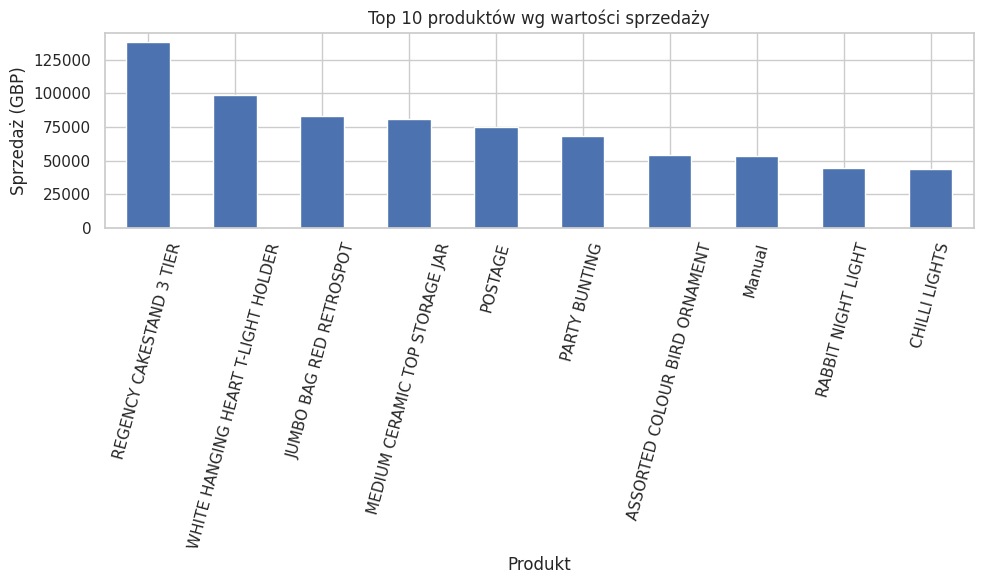

In [287]:
# Agregacja
top_products = (
    df.groupby("Description")["TotalSum"].sum().sort_values(ascending=False).head(10)
)

# Wykres
plt.figure(figsize=(10, 6))
top_products.plot(kind="bar")
plt.title("Top 10 produktów wg wartości sprzedaży")
plt.xlabel("Produkt")
plt.ylabel("Sprzedaż (GBP)")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

- niewielka liczba produktów generuje dużą część obrotu (zasada Pareto)

- produkty dekoracyjne i sezonowe dominują

## 3. Top kraje

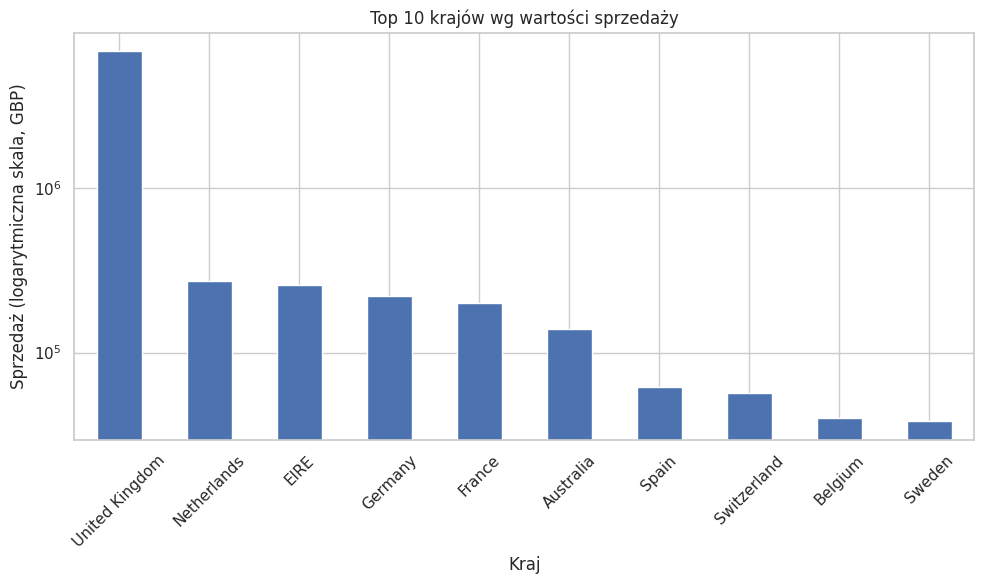

In [288]:
top_countries = (
    df.groupby("Country")["TotalSum"].sum().sort_values(ascending=False).head(10)
)

plt.figure(figsize=(10, 6))
top_countries.plot(kind="bar")
plt.title("Top 10 krajów wg wartości sprzedaży")
plt.yscale("log")
plt.xlabel("Kraj")
plt.ylabel("Sprzedaż (logarytmiczna skala, GBP)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- United Kingdom dominuje totalnie (to normalne dla zbioru OnlineRetail — to brytyjski sklep).

- Sprzedaż UK jest rzędy wielkości większa niż reszty krajów.

- Przez liniową skalę osi Y wszystkie inne kraje wyglądają jak „prawie zero”, choć realnie coś sprzedają.

Dlatego wybieramy skalę logarytmiczną: plt.yscale("log")

## 4. Liczba klientów

In [289]:
# Unikalni klienci
num_customers = df["CustomerID"].nunique()
print("Liczba unikalnych klientów:", num_customers)

Liczba unikalnych klientów: 4297


In [290]:
# Klienci miesięczni
customers_monthly = df.groupby("YearMonth")["CustomerID"].nunique().reset_index()

customers_monthly["YearMonth"] = customers_monthly["YearMonth"].astype(str)

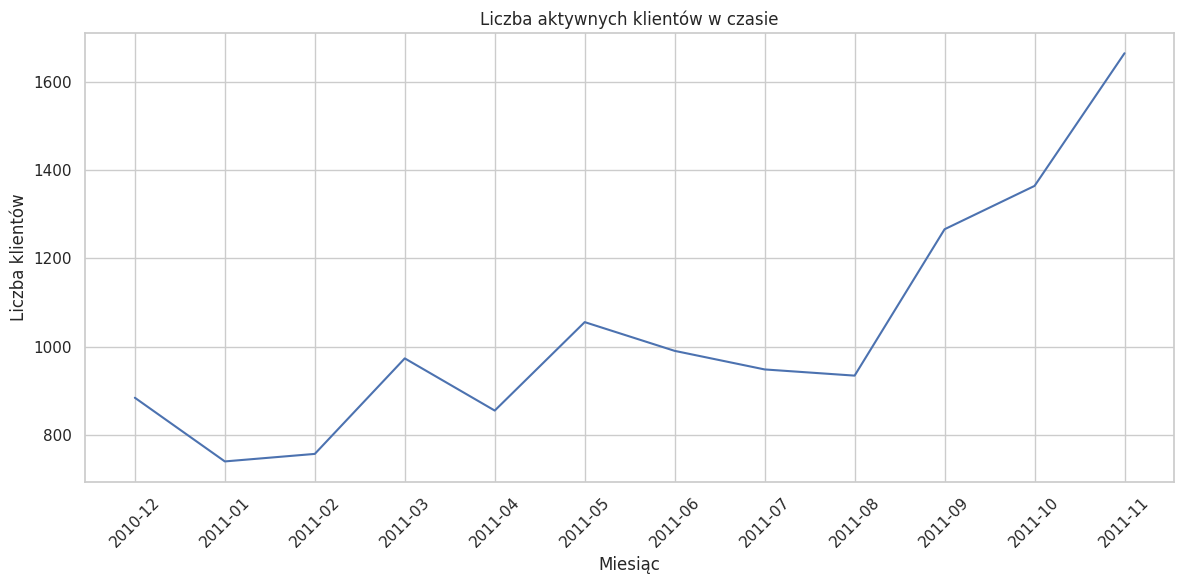

In [291]:
plt.figure(figsize=(12, 6))
plt.plot(customers_monthly["YearMonth"], customers_monthly["CustomerID"])
plt.xticks(rotation=45)
plt.title("Liczba aktywnych klientów w czasie")
plt.xlabel("Miesiąc")
plt.ylabel("Liczba klientów")
plt.tight_layout()
plt.show()


- sezonowość liczby klientów

- korelacja z wolumenem sprzedaży

- wzrost aktywności przed świętami